In [18]:
#TODO
# - fazer analise com funções quadraticas simples
# - fazer analise com funções quadraticas criadas aleatoriamente
#     - criar função para gerar quadraticas convexas e nao convexas aleatoriamente (strongly convex é facil)
# - fazer calculo do gradiente da softmax
# - 

# Bibliotecas a serem usados no projeto

In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 

# Parte 1: gradiente descendente em funções quadráticas

Ao implementar um algoritmo de descida de gradiente, podemos escolher dentre diversos métodos para escolha do tamanho do passo a ser dado. Aqui, exploraremos dois deles: short-step e busca em linha exata.

## Preparação das funções quadráticas

Sabemos que para funções diferenciáveis, uma possível definição de convexidade forte é se a função pode ser cotada inferiormente por uma quadrática de coefficiente $m>0$. Em outras palavras, temos:

$$f(y) \geq f(x)+\nabla f(x)^T(y-x)+\frac{m}{2}\|y-x\|^2 \hspace{10pt} \forall x,y \in \text{Dom}(f)$$

Além disso, se a função é duplamente continuamente diferenciável - o que seria o caso neste exercício, já que lidamos apenas com quadráticas - uma outra maneira de caracterizar convexidade forte é pela propriedade

$$ \nabla^2 f(x) \succeq mI  \implies Q - mI \succeq 0. $$

Logo, teremos que definir $Q$ de tal modo que possua paenas autovalores positivos para os casos fortemente convexos, e pelo menos um autovalor nulo para o caso convexo. A função não convexa por sua vez possuirá pelo menos um autovalor negativo.

In [85]:
def QuadraticFunction(x, Q, b, c):
    return x.T @ Q @ x + b.T @ x + c

def QuadraticGradient(x, Q, b):
    return Q @ x + b

def GeneratePSDMatrix(positiveEigValue:int=1):
    # Step 1: Choose non-negative eigenvalues
    eigenvalues = np.array([positiveEigValue, 0])  
    
    # Step 2: Generate a random orthonormal eigenvector matrix
    Q, R = np.linalg.qr(np.random.randn(2, 2), mode='complete') 
    
    # Step 3: Compute Q = V Λ V^T
    Q = Q @ np.diag(eigenvalues) @ Q.T
    return Q



## Funções fortemente convexas

Sabemos que para funções fortemente convexas, 

### Número de iterações constantes, variando condicionamento da Hessiana:

In [88]:
samples = 100
conditionNumbers = []
finalGradientNorms = []
finalObjectiveValues = []
iterations = []
maxEigs = []

gradientNormStop = 1e-3
maxSteps = 10000
# initialPoint = np.random.random_sample(2)
initialPoint = np.array([1,1])
useGradientStop = False

for q11 in range(4, 4+samples):    

    # Preparando função fortemente convexa
    Q = np.array([[q11, 0],[0, 3]])
    # Q = Q.T @ Q
    b = np.array([0,0])
    c = 0
    objective = QuadraticFunction
    objectiveGradient = QuadraticGradient
    
    # Calculando constante de Lipschitz  
    eigValues, eigvectors = np.linalg.eig(Q)
    maxEig = np.max(eigValues)
    minEig = np.min(eigValues)
    stepSize = 1/maxEig

    # Iteração zero do algoritmo
    point = initialPoint
    gradient = objectiveGradient(point, Q, b)
    gradientNorm = np.linalg.norm(gradient)
    objectiveValue = objective(point, Q, b, c)

    iter = 1
    while iter < maxSteps and (gradientNorm > gradientNormStop and useGradientStop):

        point = point - stepSize*gradient
        gradient = objectiveGradient(point, Q, b)
        gradientNorm = np.linalg.norm(gradient)
    
        iter = iter + 1

    conditionNumbers.append(maxEig/minEig)
    finalGradientNorms.append(gradientNorm)
    finalObjectiveValues.append(objective(point, Q, b, c))
    iterations.append(iter)
    maxEigs.append(maxEig)

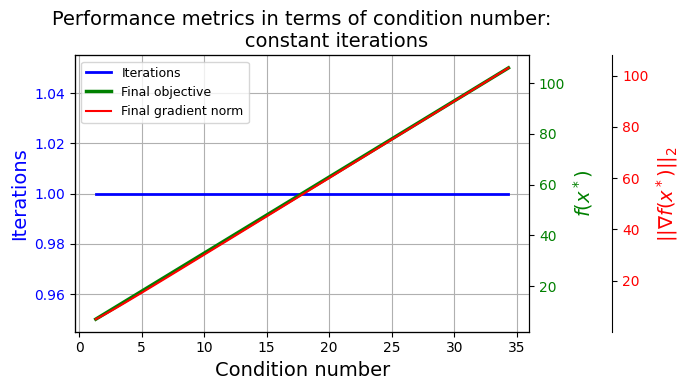

In [89]:
# Create the plot
fig, ax1 = plt.subplots(figsize=(7, 4))

# Plot the first curve
ax1.plot(conditionNumbers, [i for i in iterations], label='Iterations', color='blue', linewidth=2)
ax1.set_xlabel('Condition number', fontsize=14)
ax1.set_ylabel('Iterations', fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(conditionNumbers, finalObjectiveValues, label='Final objective', color='green', linewidth=2.5)
ax2.set_ylabel('$f(x^*)$', fontsize=14, color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Create a third y-axis
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis
ax3.plot(conditionNumbers, finalGradientNorms, label='Final gradient norm', color='red', linewidth=1.5)
ax3.set_ylabel('$|| \\nabla f(x^*) ||_2$', fontsize=14, color='red')
ax3.tick_params(axis='y', labelcolor='red')

# Add a title and grid
plt.title('Performance metrics in terms of condition number:\n \
          constant iterations', fontsize=14)
ax1.grid(True)

# Add a legend
lines = ax1.get_lines() + ax2.get_lines() + ax3.get_lines()
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, fontsize=9, loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()


## Funções convexas, com ao menos 1 autovalor = 0:

In [102]:
samples = 100
conditionNumbers = []
finalGradientNorms = []
finalObjectiveValues = []
iterations = []
maxEigs = []

gradientNormStop = 1e-3
maxSteps = 10000
# initialPoint = np.random.random_sample(2)
initialPoint = np.array([1,1])
useGradientStop = False

for positiveEigValue in np.linspace(4, 1000, samples):    

    # Preparando função fortemente convexa
    Q = GeneratePSDMatrix(positiveEigValue)
    b = np.array([0,0])
    c = 0
    objective = QuadraticFunction
    objectiveGradient = QuadraticGradient
    
    # Calculando constante de Lipschitz  
    eigValues, eigvectors = np.linalg.eig(Q)
    maxEig = np.max(eigValues)
    minEig = np.min(eigValues)
    stepSize = 1/maxEig

    # Iteração zero do algoritmo
    point = initialPoint
    gradient = objectiveGradient(point, Q, b)
    gradientNorm = np.linalg.norm(gradient)
    objectiveValue = objective(point, Q, b, c)

    iter = 1
    while iter < maxSteps and (gradientNorm > gradientNormStop and useGradientStop):

        point = point - stepSize*gradient
        gradient = objectiveGradient(point, Q, b)
        gradientNorm = np.linalg.norm(gradient)
    
        iter = iter + 1

    conditionNumbers.append(maxEig)
    finalGradientNorms.append(gradientNorm)
    finalObjectiveValues.append(objective(point, Q, b, c))
    iterations.append(iter)
    maxEigs.append(maxEig)

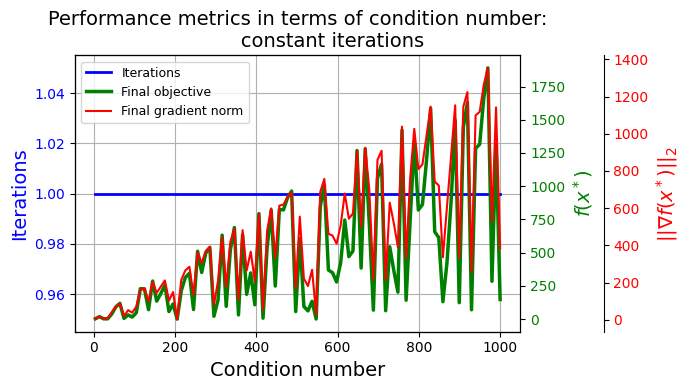

In [103]:
# Create the plot
fig, ax1 = plt.subplots(figsize=(7, 4))

# Plot the first curve
ax1.plot(conditionNumbers, [i for i in iterations], label='Iterations', color='blue', linewidth=2)
ax1.set_xlabel('Condition number', fontsize=14)
ax1.set_ylabel('Iterations', fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(conditionNumbers, finalObjectiveValues, label='Final objective', color='green', linewidth=2.5)
ax2.set_ylabel('$f(x^*)$', fontsize=14, color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Create a third y-axis
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis
ax3.plot(conditionNumbers, finalGradientNorms, label='Final gradient norm', color='red', linewidth=1.5)
ax3.set_ylabel('$|| \\nabla f(x^*) ||_2$', fontsize=14, color='red')
ax3.tick_params(axis='y', labelcolor='red')

# Add a title and grid
plt.title('Performance metrics in terms of condition number:\n \
          constant iterations', fontsize=14)
ax1.grid(True)

# Add a legend
lines = ax1.get_lines() + ax2.get_lines() + ax3.get_lines()
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, fontsize=9, loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

## Plot de exemplos de funções fortemente convexas, convexas e não convexas  

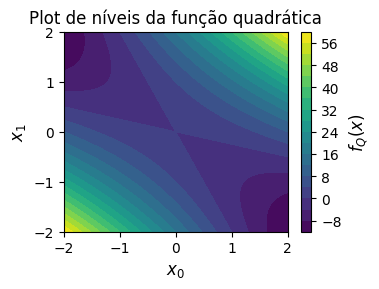

In [9]:
# Calculando valores das funções 
x0 = np.linspace(-2, 2, 1000)
x1 = np.linspace(-2, 2, 1000)

functionValuesQ = discretizedFunction(x0, x1, ConvexQuadratic)

# Criando plot
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))

# Plot da função quadrática
contour1 = ax1.contourf(x0, x1, functionValuesQ, levels=20, cmap='viridis')
colorBar1 = fig.colorbar(contour1, ax=ax1)
colorBar1.set_label(label='$f_Q(x)$', fontsize=12)
ax1.set_xlabel('$x_0$', fontsize=12)
ax1.set_ylabel('$x_1$', fontsize=12)
ax1.set_title('Plot de níveis da função quadrática', fontsize=12)
ax1.axis('tight')


plt.tight_layout()
plt.show()

## Gradiente descendente com busca em linha exata

## Gradiente descendente com short-step

# Parte 2: classificação multinomial no dataset MNIST

## Cáculo do gradiente da função objetivo softmax

A função custo para a regressão logística multinomial é dada por

$$ J(\theta) = -\left[ \sum_{i=1}^{m}\sum_{k=1}^{K} \delta(y^i=k) \log \left( \frac{\exp ({\theta^k}^Tx^i)}{\sum_{j=1}^{K}\exp({\theta^j}^Tx^i)} \right) \right], $$


e seu gradiente por sua vez é

$$ \nabla_{\theta^k}J(\theta) = -\sum_{i=1}^{m} \left[ x^i (\delta (y^i=k) - \frac{\exp ({\theta^k}^Tx^i)}{\sum_{j=1}^{K}\exp({\theta^j}^Tx^i)} ) \right] $$ 


## Carregando base de dados MNIST e preparando conjuntos de treino/teste

In [147]:
# Load the MNIST dataset
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()


# Convertendo matrizes de pixels em uma lista 
x_train = np.array([array.reshape(-1) for array in x_train])
x_test = np.array([array.reshape(-1) for array in x_test])


# One-hot enconding para a classificação de cada dado
y_train = np.eye(10, dtype=int)[y_train]
y_test = np.eye(10, dtype=int)[y_test]


# Normalize the images to [0, 1] range
# x_train, x_test = (x_train-0.5) / 255.0, (x_test-0.5) / 255.0
x_train, x_test = (x_train) / 255.0, (x_test) / 255.0
x_train = np.insert(x_train, 0, 1, axis=1)
x_test = np.insert(x_test, 0, 1, axis=1)



x_train = x_train[:10]
y_train = y_train[:10]
x_test = x_test[:10]
y_test = y_test[:10]

In [148]:
def Softmax(w:np.array, x:np.array, y:np.array):
    
    K = len(y[0])
    m = len(y)
    objective = 0
    for i in range(m):
        for k in range(K):
            objective = objective - y[i, k] * np.log( (np.exp(w[k] @ x[i])) / (np.sum( w @ x[i] )) )

    return objective

def SoftmaxGradient(w:np.array, x:np.array, y:np.array, k:int):

    K = len(y[0])
    m = len(y)
    n = len(x[0])

    gradient = np.zeros(n)

    for i in range(m):
        gradient = gradient - x[i] * (y[i, k] - (np.exp(w[k] @ x[i])) / (np.sum( w @ x[i] )))

    return gradient

In [ ]:
K = len(y_train[0])
m = len(y_train)
n = len(x_train[0])

samples = 100
useGradientStop = True


gradientNormStop = 1e-3
maxSteps = 1000

w = np.random.random_sample((K, n))

conditionNumbers = []
finalGradientNorms = []
finalObjectiveValues = []
iterations = []
maxEigs = []

objective = Softmax
objectiveGradient = SoftmaxGradient

iter = 1
while iter < maxSteps and (gradientNorm > gradientNormStop and useGradientStop):

    for k in range(K):
        gradient = objectiveGradient(w, x_train, y_train, k)
        gradientNorm = np.linalg.norm(gradient)
        objectiveValue = objective(w, x_train, y_train)
        w = w - gradientNorm*gradient

    iter = iter + 1
    print(iter)



In [162]:
print(w @ x_train[0])
print(y_train[0])

[50.50270988 54.05252699 53.71823834 52.00122714 51.14994651 56.95658882
 56.75529184 54.07899403 56.41911494 54.43821637]
[0 0 0 0 0 1 0 0 0 0]


In [133]:
N = len(x_train)
K = 10
d = len(x_train[0])
learningRate = 0.5

points = np.random.random_sample((K, d))

# Preparando parametros para rodar gradiente descendente
maxSteps = 10
iter = 1
gradientNormStop = 1e-3

while iter < maxSteps:

    exponentials = np.zeros(K)
    softmaxTerms = np.zeros(K)
    gradient = np.zeros((K,d))
    
    for dataPointIndex in range(N):
        
        # Prepara o discriminante do ponto atual para cada classe do problema
        # for categoryIndex in range(K):
        #     normalizationCoeffs[categoryIndex] = normalizationCoeffs[categoryIndex] + points @ x_train[dataPointIndex]
        
        exponentials = points @ x_train[dataPointIndex]
        
        # Prepara termos da softmax
        for categoryIndex in range(K):
            softmaxTerms[categoryIndex] = np.exp(exponentials[categoryIndex]) / np.sum(exponentials)
        pass
        # Cálculo do gradiente
        for categoryIndex in range(K):
            gradient[categoryIndex] = (y_train[dataPointIndex][categoryIndex] - softmaxTerms[categoryIndex])* x_train[dataPointIndex]
    
        points = points + np.linalg.norm(gradient) * gradient
    
    
    iter = iter + 1
    print(iter)




2
3
4
5
6
7
8
9
10


In [134]:
print(points @ x_train[0])
print(y_train[0])


[-7.33718110e+45 -1.38703556e+47 -2.36670928e+47 -1.21194433e+47
 -1.75495704e+44 -4.97609582e+46 -7.43958727e+45 -1.56323821e+45
 -2.37761671e+48 -1.05317978e+45]
[0 0 0 0 0 1 0 0 0 0]


In [107]:
print(type(x_train))
print(x_train.shape)

print(type(x_train[0]))
print(x_train[0].shape)

print(type(y_train))
print(y_train.shape)

print(type(y_train[0]))
print(y_train[0].shape)


<class 'numpy.ndarray'>
(60000, 784)
<class 'numpy.ndarray'>
(784,)
<class 'numpy.ndarray'>
(60000, 10)
<class 'numpy.ndarray'>
(10,)
